## Recycled code to make vertical slices along path of TTide beam

In [1]:
from matplotlib import rc
# rc('font', **{'size':12})
# rc('text', usetex=True)
# rc('xtick', labelsize=12) 
# rc('ytick', labelsize=12) 
# rc('axes', titlesize=16)    # fontsize of the axes title
# rc('axes', labelsize=12)    # fontsize of the x and y labels
from xmovie import Movie 
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import timeit

from scipy.fft import fft,fftfreq

import numpy as np
from netCDF4 import Dataset
import os
import xarray as xr
from xgcm import Grid
from dask.distributed import Client
import dask.array as da
import cmocean.cm as cm                              # Nice colormaps
from collections import OrderedDict               # We often use this to organise our experiments
import cftime                                     # In case you need to work with time axes

# db='flat_topo.db'
# session=cc.database.create_session(db)
# dir_list = '/scratch/v45/ab8992/mom6/archive/custom_forcing_flat_topo'
# cc.database.build_index(dir_list,session)
def fix_zcoord(tracer_transect,layer_thickness):
    """
    This function takes a transect in the z direction of some quantity of interest as well as the
    layer thickness file, and returns the transect with a 'depth' coordinate. This z coordinate is
    the accumulative sum of layer thicknesses rather than the fixed 'zl' dimension
    
    Parameters:
        tracer_transect (xarray.DataArray) : Transect of some quantity of interest
        layer_thickness (xarray.DataArray) : Layer thickness for model run
        
    Returns:
        new_zcoord (xarray.DataArray) : Transect with 'depth' coordinate
        
    """
    
    # Retrieve time as well as x and y slices from the transect
    time = tracer_transect.coords["time"].values.reshape(1)[0]
    
    if len(tracer_transect.xh.dims) == 0:
        xslice = float(tracer_transect.xh.values)
    else:
        xslice = slice(tracer_transect.coords["xh"].values[0],tracer_transect.coords["xh"].values[-1])
    if len(tracer_transect.yh.dims) == 0:
        yslice = float(tracer_transect.yh.values)
    else:
        yslice = slice(tracer_transect.coords["yh"].values[0],tracer_transect.coords["yh"].values[-1])
    
    # Calculate accumulative sum of layer_thicknesses over appropriate transect
    accdepth = layer_thickness.sel(time=time,method="nearest").sel(xh=xslice,method="nearest").sel(yh=yslice).cumsum(dim="zl")
    
    print("Transect time:       ",time,"\nNearest Zcoord time: ", accdepth.coords["time"].values.reshape(1)[0])
    
    # Create a new dataarray with depth coordinate
    new_zcoord = xr.DataArray(
        data=tracer_transect.values,
        dims=["zl", "yh"],
        coords=dict(
            yh=(["yh"], tracer_transect.yh),
            depth=(["zl", "yh"], accdepth.values),
        ),
        attrs= tracer_transect.attrs
    )
    return new_zcoord

from dask.distributed import Client
client = Client()
client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38803 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/38803/status,
Dashboard: /proxy/38803/status,Workers: 7
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37369,Workers: 7
Dashboard: /proxy/38803/status,Total threads: 28
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:42767,Total threads: 4
Dashboard: /proxy/44431/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:34231,


In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Figure out where to put our slice

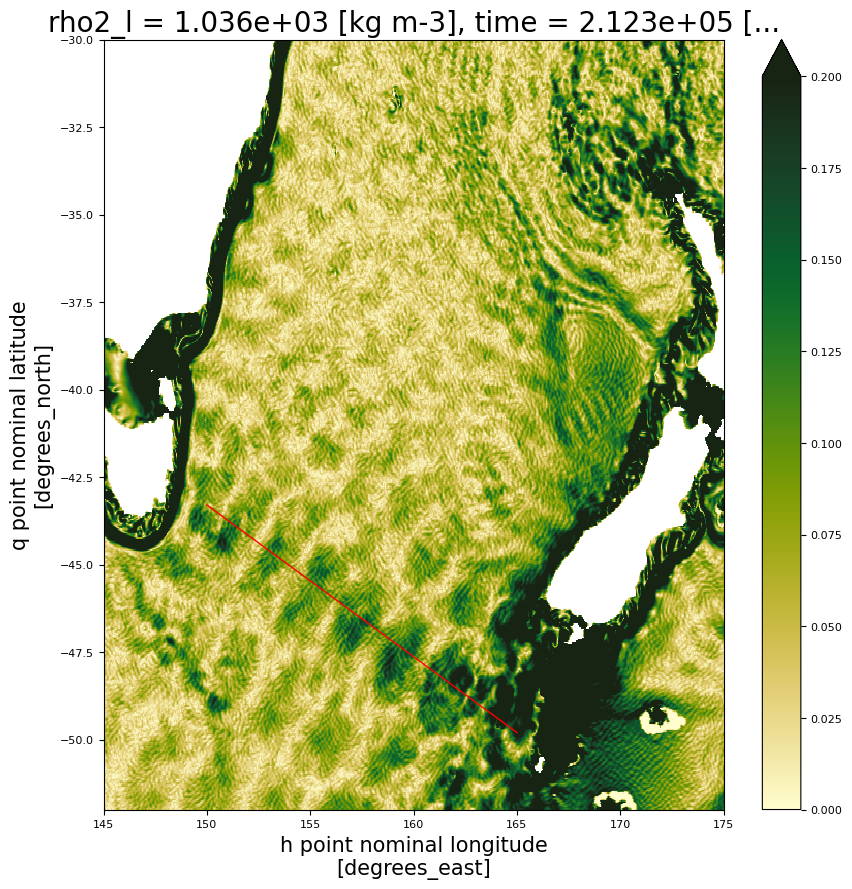

In [28]:
%matplotlib inline

expt = "blank-ttide-20"
movietitle = "hourly_deepspeed-mixed.mp4"

e = xr.open_mfdataset(f"/home/149/ab8992/mom6_rundirs/ttide/{expt}/archive/output007/*hourly_e.nc",decode_times = False, parallel = True,chunks = "auto").sel(xh = slice(145,175),yh = slice(-52,-30))

v = xr.open_mfdataset(f"/home/149/ab8992/mom6_rundirs/ttide/{expt}/archive/output007/*hourly_v.nc",decode_times = False, parallel = True,chunks = "auto").sel(xh = slice(145,175),yq = slice(-52,-30))
u = xr.open_mfdataset(f"/home/149/ab8992/mom6_rundirs/ttide/{expt}/archive/output007/*hourly_u.nc",decode_times = False, parallel = True,chunks = "auto").sel(xq = slice(145,175),yh = slice(-52,-30))



speed = np.sqrt((v.interp({"yq":u.yh.values}).rename({"yq":"yh"})**2).v + (u.interp({"xq":v.xh.values}).rename({"xq":"xh"})**2).u).isel(time = 50).load()
e = e.e.isel(time = 50).load()


fig,ax = plt.subplots(figsize = (10,10))
speed.plot(ax = ax,vmax = 0.2,cmap = cm.cm.speed)
ax.plot([150,165],[-43.3,-49.8],color = "red",linewidth = 1)

## Make slices and fix depth coordinate

For new runs (or new analysis) remake the u slice, v slice and speed diagnostics. Note that 'speed' isn't given the new depth coordinate because it's just so expensive and chunky to store

In [2]:
## Use Andy's code to modify u and put on new depth axis
%matplotlib inline
import subprocess
## Vertical slice vector

def get_transect_data(vector,expt,output):
    """
    Returns a dataset ready to be passed to transect movie maker

    Requires an expt/output with isopycnal heights, z* velocities z* thicknesses
    """

    ## Need to modify longitude to ensure we're comparing distances correctly
    longitude_factor = np.cos(-47.5 * np.pi / 180)

    dist = 1352 ## Length of transect

    ## Angle from horizontal to the beam path
    theta = np.arctan(
        (vector[0,1] - vector[1,1]) / (longitude_factor * (vector[0,0] - vector[1,0]))
    )
    basepath = f"/home/149/ab8992/mom6_rundirs/ttide/{expt}/archive/output?({'|'.join(output)})/*"
    print(basepath)
    if type(output) != list:
        output = [output]


    ## Messy bit of code that creates lists containing each nc file of interest. extglob makes sure we have the right character matching...
    hpaths = subprocess.run(f"shopt -s extglob \n ls {basepath}hourly_h.nc",shell=True,capture_output=True).stdout.decode("utf-8").rstrip().split("\n")
    upaths = subprocess.run(f"shopt -s extglob \n ls {basepath}hourly_u.nc",shell=True,capture_output=True).stdout.decode("utf-8").rstrip().split("\n")
    vpaths = subprocess.run(f"shopt -s extglob \n ls {basepath}hourly_v.nc",shell=True,capture_output=True).stdout.decode("utf-8").rstrip().split("\n")
    epaths = subprocess.run(f"shopt -s extglob \n ls {basepath}hourly_e.nc",shell=True,capture_output=True).stdout.decode("utf-8").rstrip().split("\n")

    h = xr.open_mfdataset(hpaths,decode_times = False, parallel = True,chunks = "auto").sel(xh = slice(145,175),yh = slice(-52,-30))
    v = xr.open_mfdataset(vpaths,decode_times = False, parallel = True,chunks = "auto").sel(xh = slice(145,175),yq = slice(-52,-30))
    u = xr.open_mfdataset(upaths,decode_times = False, parallel = True,chunks = "auto").sel(xq = slice(145,175),yh = slice(-52,-30))
    isop = xr.open_mfdataset(epaths,decode_times = False, parallel = True,chunks = "auto").sel(xh = slice(145,175),yh = slice(-52,-30))

    ## Construct transect
    x = xr.DataArray(np.arange(150,165,0.1),dims="l")
    y = xr.DataArray(np.linspace(-43.3,-49.8,x.shape[0]),dims="l")
    # fig,ax = plt.subplots(1,figsize = (10,10))

    u_transect = u.interp(xq = x,yh = y)
    v_transect = v.interp(xh = x,yq = y)
    h_transect = h.interp(xh = x,yh = y)
    isop_transect = isop.interp(xh = x,yh = y)

    ## Calculate velocity along transect
    ul = u_transect.u * np.cos(theta)  + v_transect.v * np.sin(theta)
    ul = ul.assign_coords({"l":('l',np.linspace(0,dist,ul.l.shape[0]))})
    h_transect = h_transect.assign_coords({"l":('l',np.linspace(0,dist,h_transect.l.shape[0]))})
    ul = ul.load()
    h_transect = h_transect.h.load()
    isop_transect = isop_transect.load()
    depth = h_transect.cumsum(dim='zl')
    u_newz = xr.DataArray(data=ul.values,dims=["time","zl", "l"],
            coords=dict(l=(["l"], ul.l.values),depth=(["time","zl", "l"], depth.values)),
            attrs= ul.attrs)

    data = xr.Dataset(
        data_vars = {"h_transect":h_transect,
            "isop_transect":isop_transect.e,
            "depth":depth,
            "u_newz":u_newz})
    data = data.chunk({"time":1})

    return data



def plotvtransect(data,fig,tt,framedim = "time"):
    ax = fig.subplots(1)


    data.u_newz.isel(time = tt).plot(vmin = -0.4,vmax = 0.4,cmap = cm.balance,ax = ax,y = "depth",add_colorbar = False)



    for ii in range(20,80,10):
        ax.plot(data.u_newz.l.values,-1 * data.isop_transect[tt,ii,:],'green',linewidth=1)

    for ii in range(data.h_transect.shape[1] - 1):
        ax.plot(data.u_newz.l.values,data.depth[tt,ii,:],'black',linewidth=0.1)

    ax.fill_between(data.u_newz.l.values,data.depth[tt,-1,:],5500,color = "gray")
    ax.set_ylim(0,5500)
    ax.invert_yaxis()
    ax.set_xlabel(r"Tasmania $\longleftarrow $                  Distance (km)                  $\longrightarrow $ Macquarie Ridge")
    ax.set_title("Velocity along transect with 1036 - 1037 rho2 isopycnal heights")
    return 


vector = np.array([[150,-49.8],[165,-43.3]])
# data = get_transect_data(vector,"testtides-20",["011","012"])
data = get_transect_data(vector,"ttide-20",["011"])

/home/149/ab8992/mom6_rundirs/ttide/ttide-20/archive/output?(011)/*


In [56]:
outputs = ["011","012"]
expt="testtides-20"
basepath = f"/home/149/ab8992/mom6_rundirs/ttide/{expt}/archive/output?({'|'.join(outputs)})/*hourly_h.nc"
print(basepath)

import glob
glob.glob(f"/home/149/ab8992/mom6_rundirs/ttide/{expt}/archive/output012/*hourly")


/home/149/ab8992/mom6_rundirs/ttide/testtides-20/archive/output?(011|012)/*hourly_h.nc


[]

In [69]:
a = subprocess.run(f"shopt -s extglob \n ls {basepath}",shell=True,capture_output=True)
b = a.stdout.decode("utf-8") 
b.rstrip().split("\n")

['/home/149/ab8992/mom6_rundirs/ttide/testtides-20/archive/output011/20150501.hourly_h.nc',
 '/home/149/ab8992/mom6_rundirs/ttide/testtides-20/archive/output012/20150511.hourly_h.nc']

## Make movie of blank tides

KeyboardInterrupt: 

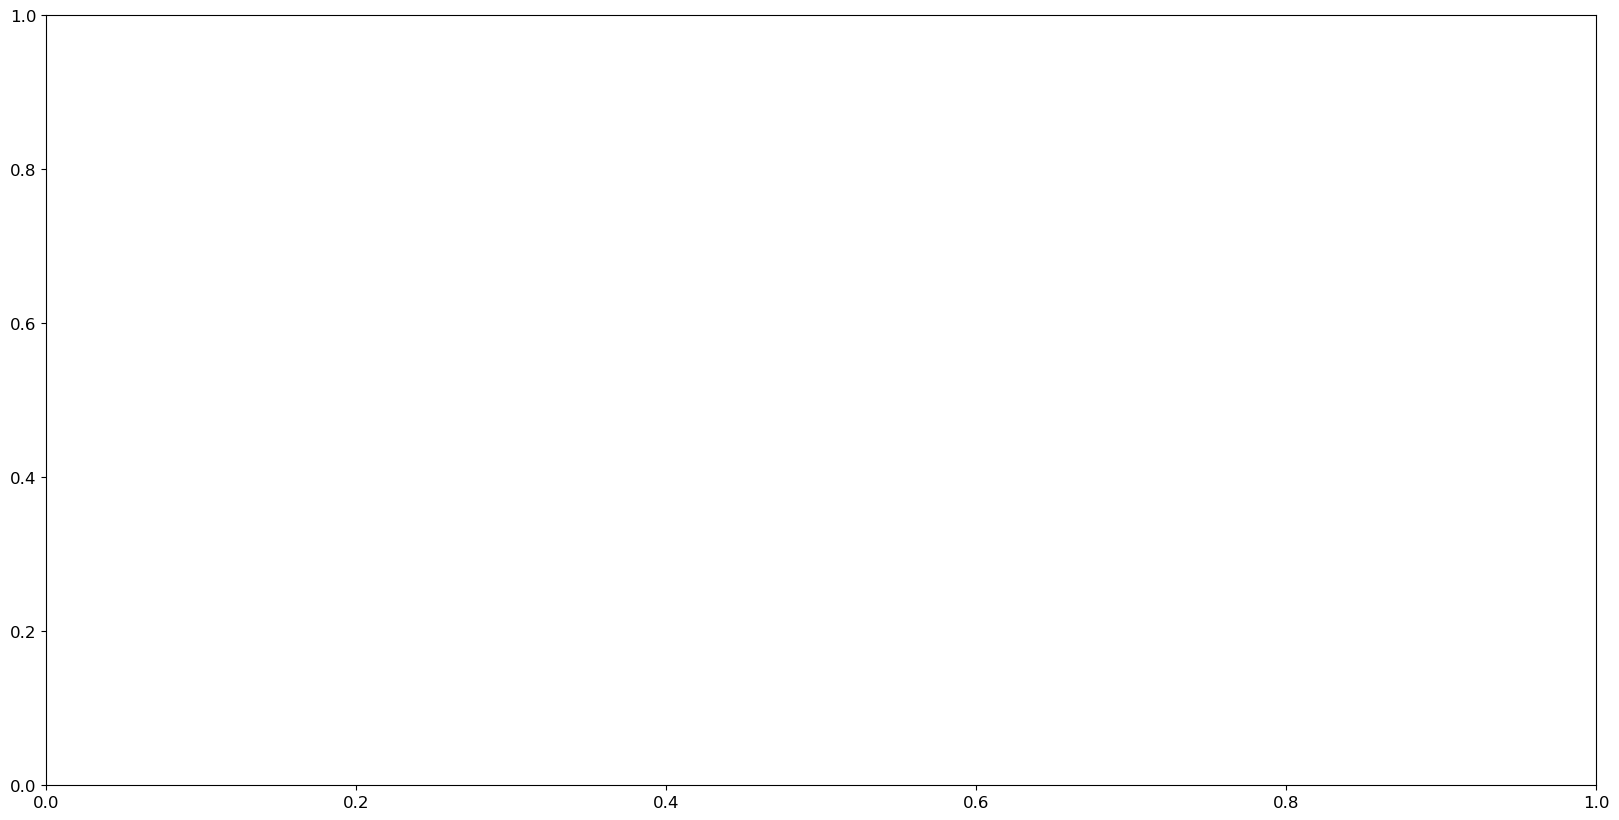

Process Dask Worker process (from Nanny):
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/distributed/process.py", line 202, in _run
    target(*args, **kwargs)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/distributed/nanny.py", line 990, in _run
    asyncio.run(run())
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/asyncio/runners.py", line 47, in run
    _cancel_all_tasks(loop)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/asyncio/runners.py", line 63, in _cancel_all_tasks
    loop.run_unt

In [11]:
fig,ax = plt.subplots(1,figsize = (20,10))

data = get_transect_data(vector,"blank-ttide-20","output012")

mov = Movie(data,plotvtransect,input_check = False)
mov.save("/g/data/v45/ab8992/dropbox/regional_movies/" + "transect-blanktides.mp4",overwrite_existing = True,parallel = True,parallel_compute_kwargs=dict(scheduler="processes", num_workers=28)) # ,

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/dask/base.py:1368: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/xmovie/core.py:348: UserWarning: The provided `plotfunc` does not provide the expected number of output arguments.            Expected a function `ax,pp =plotfunc(...)` but got %i output arguments. Inserting dummy values. This should not affect output. 
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/xmovie/core.py:348: UserWarning: The provided `plotfunc` does not provide the expected number of output arguments.            Expected a function `ax,pp =plotfunc(...)` but got %i output arguments. Inserting dummy values. This should not affect output. 
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3

Movie created at transect-mixed.mp4


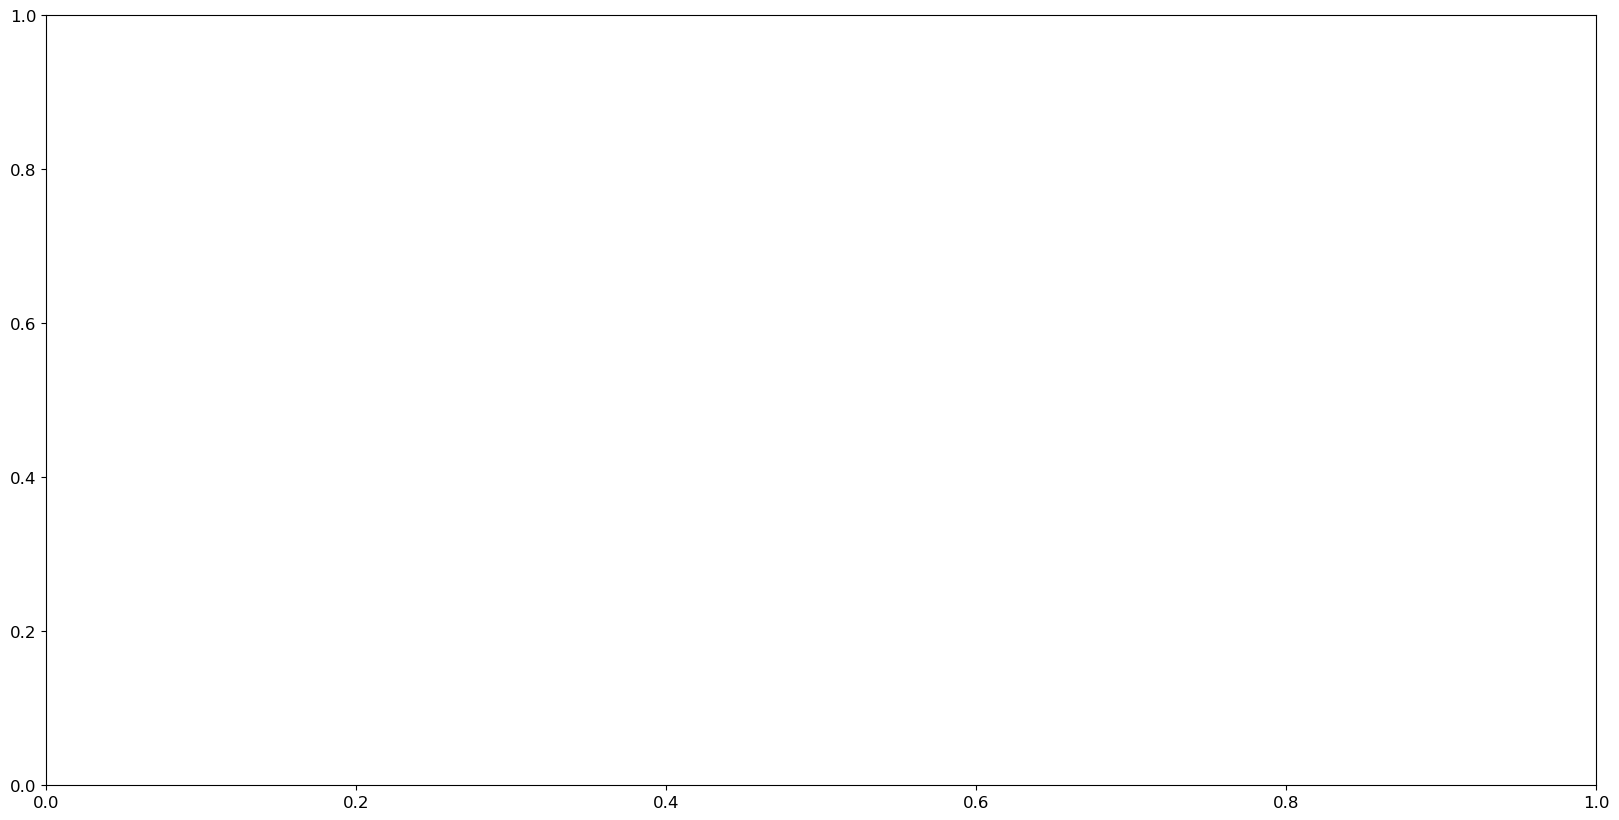

In [27]:
fig,ax = plt.subplots(1,figsize = (20,10))


data = get_transect_data(vector,"testtides-20","output010")

mov = Movie(data,plotvtransect,input_check = False)
mov.save("/g/data/v45/ab8992/dropbox/regional_movies/" + "transect-mixed.mp4",overwrite_existing = True,parallel = True,parallel_compute_kwargs=dict(scheduler="processes", num_workers=28)) # ,

## Movie of no tides

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/dask/base.py:1368: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/xmovie/core.py:348: UserWarning: The provided `plotfunc` does not provide the expected number of output arguments.            Expected a function `ax,pp =plotfunc(...)` but got %i output arguments. Inserting dummy values. This should not affect output. 
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/xmovie/core.py:348: UserWarning: The provided `plotfunc` does not provide the expected number of output arguments.            Expected a function `ax,pp =plotfunc(...)` but got %i output arguments. Inserting dummy values. This should not affect output. 
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3

Movie created at transect-notide.mp4


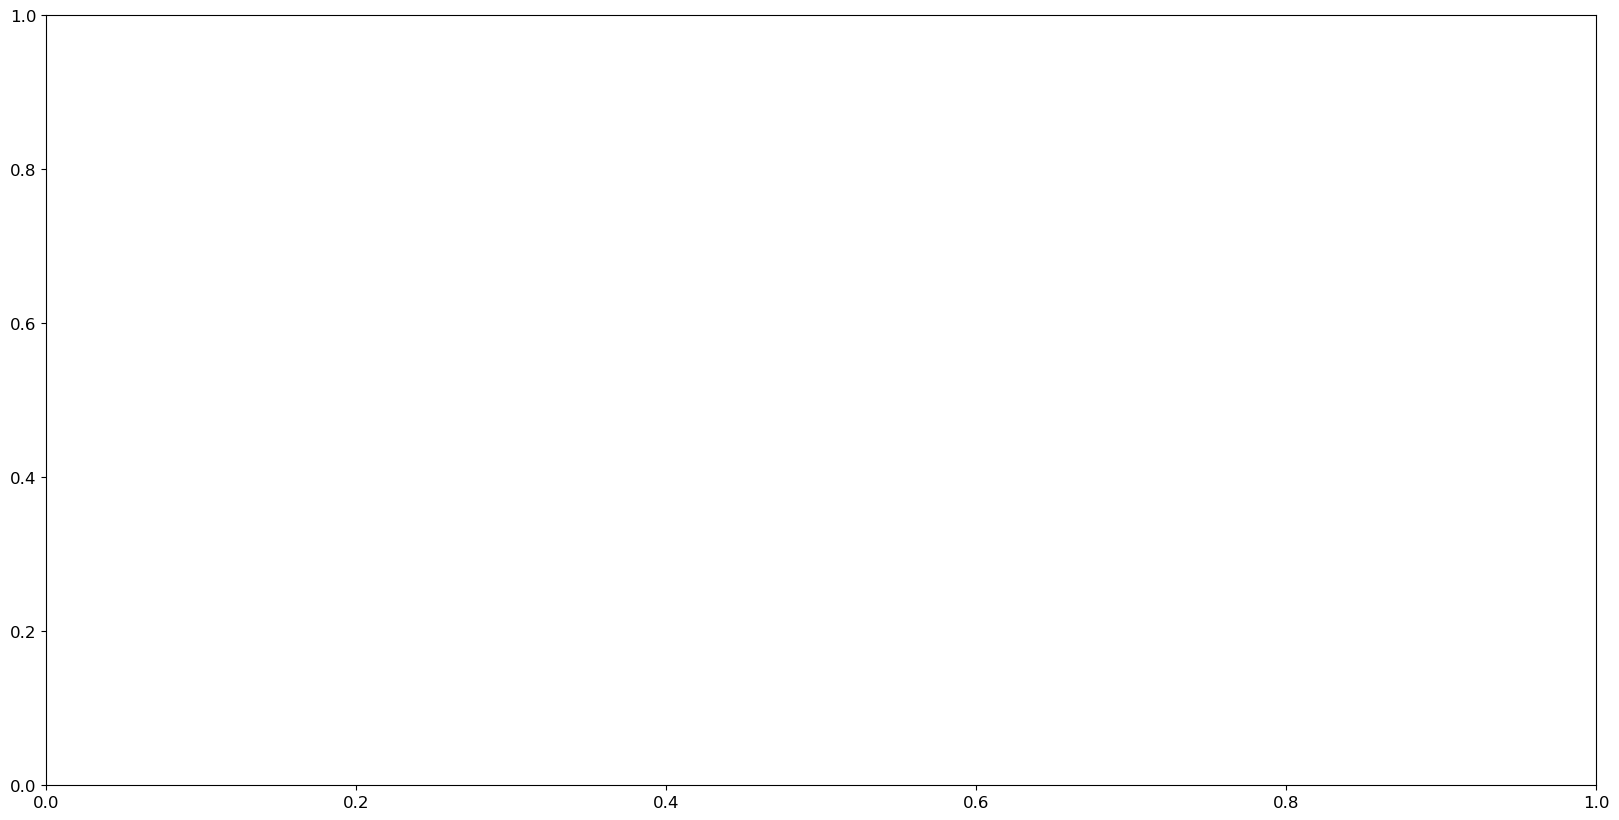

2023-07-25 01:54:54,002 - distributed.nanny - WARNING - Restarting worker
2023-07-25 01:54:54,084 - distributed.nanny - WARNING - Restarting worker
2023-07-25 01:54:54,390 - distributed.nanny - WARNING - Restarting worker
2023-07-25 01:54:55,398 - distributed.nanny - WARNING - Restarting worker


In [84]:
fig,ax = plt.subplots(1,figsize = (20,10))


data = get_transect_data(vector,"ttide-20","output011")

mov = Movie(data,plotvtransect,input_check = False)
mov.save("/g/data/v45/ab8992/dropbox/regional_movies/" + "transect-notide.mp4",overwrite_existing = True,parallel = True,parallel_compute_kwargs=dict(scheduler="processes", num_workers=28)) # ,

## Test double plot dimensions

Text(0.5, 1.0, 'Density along transect')

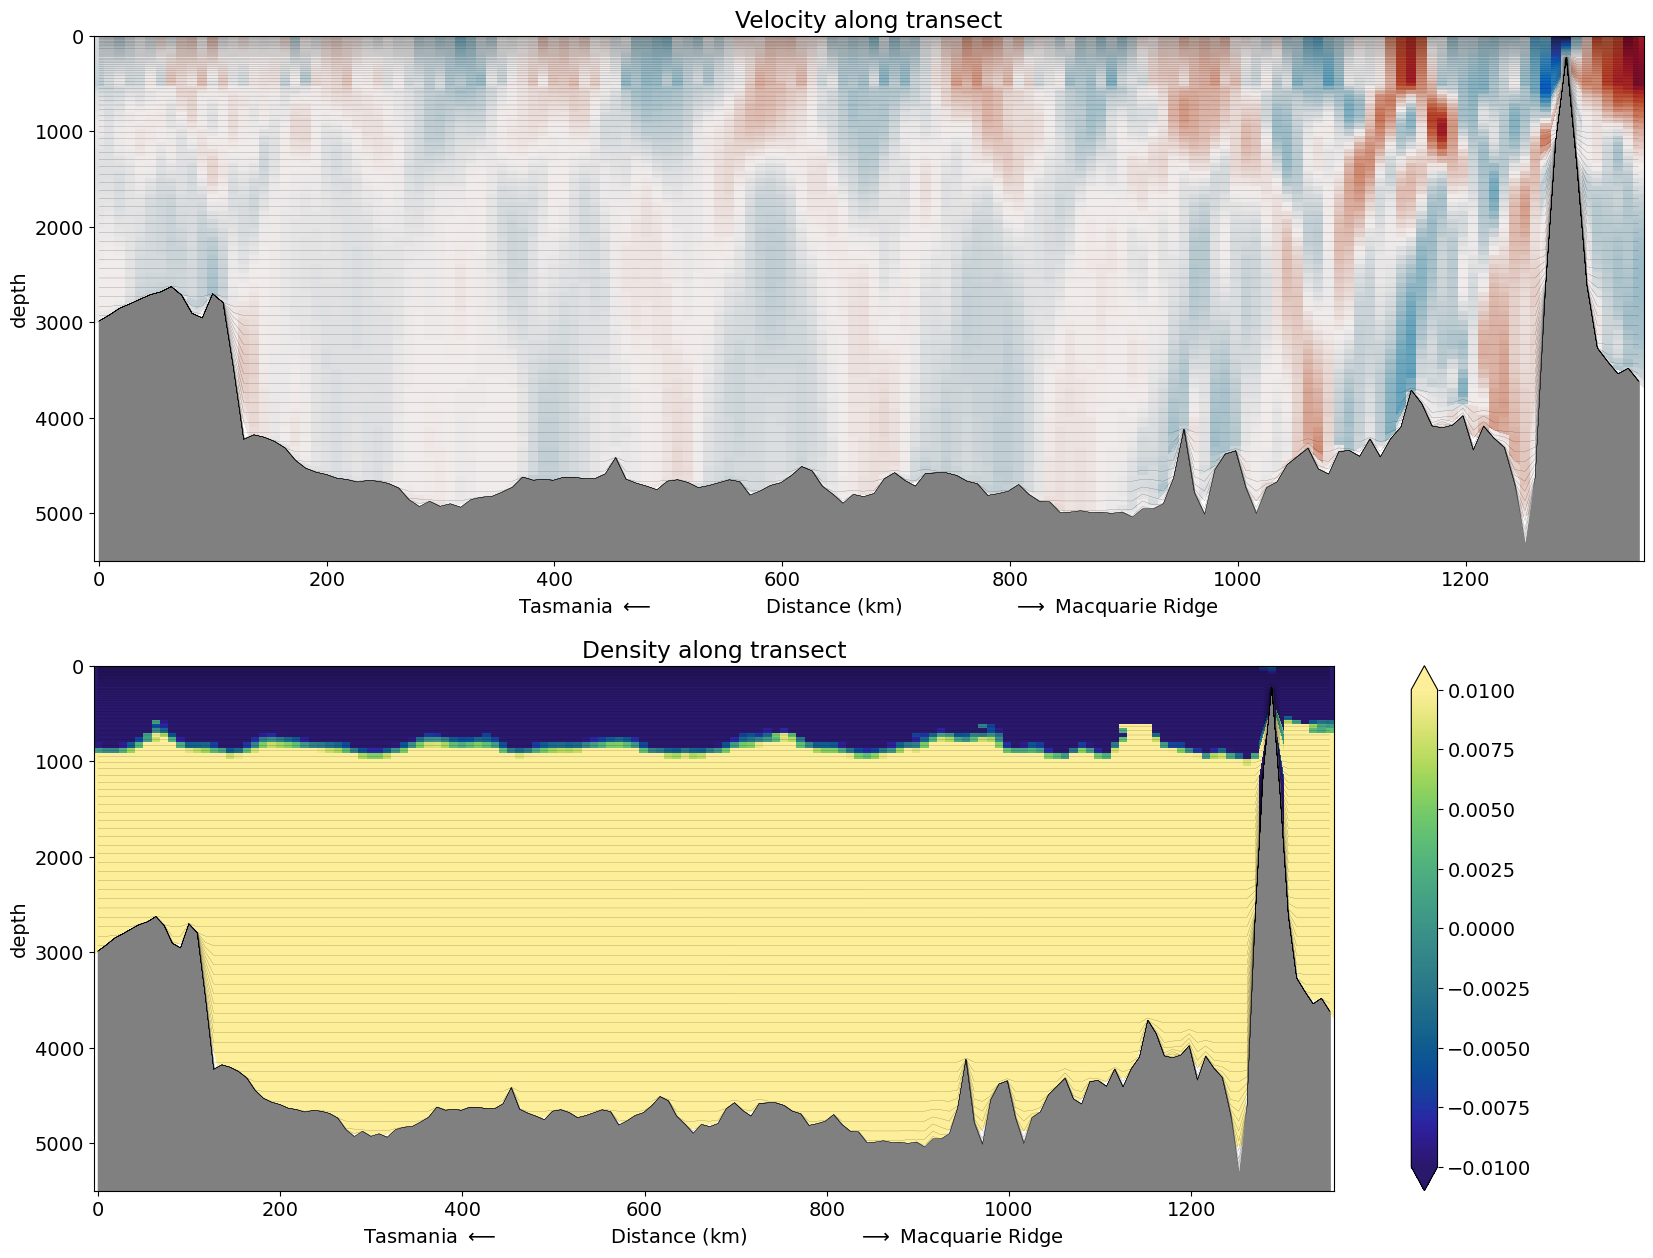

In [22]:
## Use Andy's code to modify u and put on new depth axis
%matplotlib inline
depth = h_transect.h.cumsum(dim='zl')
u_fixed = xr.DataArray(data=ul.values,dims=["time","zl", "l"],
        coords=dict(l=(["l"], ul.l.values),depth=(["time","zl", "l"], depth.values)),
        attrs= ul.attrs)
rho_fixed = xr.DataArray(data=rho_transect.values,dims=["time","zl", "l"],
        coords=dict(l=(["l"], rho_transect.l.values),depth=(["time","zl", "l"], depth.values)),
        attrs= rho_transect.attrs)

fig,ax = plt.subplots(2,figsize = (20,15))


u_fixed.isel(time = 25).plot(vmin = -0.4,vmax = 0.4,cmap = cm.balance,ax = ax[0],y = "depth",add_colorbar=False)

for ii in range(h_transect.h.shape[1] - 1):
    ax[0].plot(u_fixed.l.values,depth[25,ii,:],'black',linewidth=0.1)

ax[0].fill_between(u_fixed.l.values,depth[25,-1,:],5500,color = "gray")
ax[0].set_ylim(0,5500)
ax[0].invert_yaxis()
ax[0].set_xlabel(r"Tasmania $\longleftarrow $                  Distance (km)                  $\longrightarrow $ Macquarie Ridge")
ax[0].set_title("Velocity along transect")

rho_fixed.isel(time = 25).plot(cmap = cm.haline,ax = ax[1],y = "depth",vmin = -0.01,vmax = 0.01)

for ii in range(h_transect.h.shape[1] - 1):
    ax[1].plot(rho_fixed.l.values,depth[25,ii,:],'black',linewidth=0.1)

ax[1].fill_between(rho_fixed.l.values,depth[25,-1,:],5500,color = "gray")
ax[1].set_ylim(0,5500)
ax[1].invert_yaxis()
ax[1].set_xlabel(r"Tasmania $\longleftarrow $                  Distance (km)                  $\longrightarrow $ Macquarie Ridge")
ax[1].set_title("Density along transect")

## Make Hovmollers of our transects with same data as movies

Text(0.5, 1.0, 'Hovmöller plot of interfacial height anomolies')

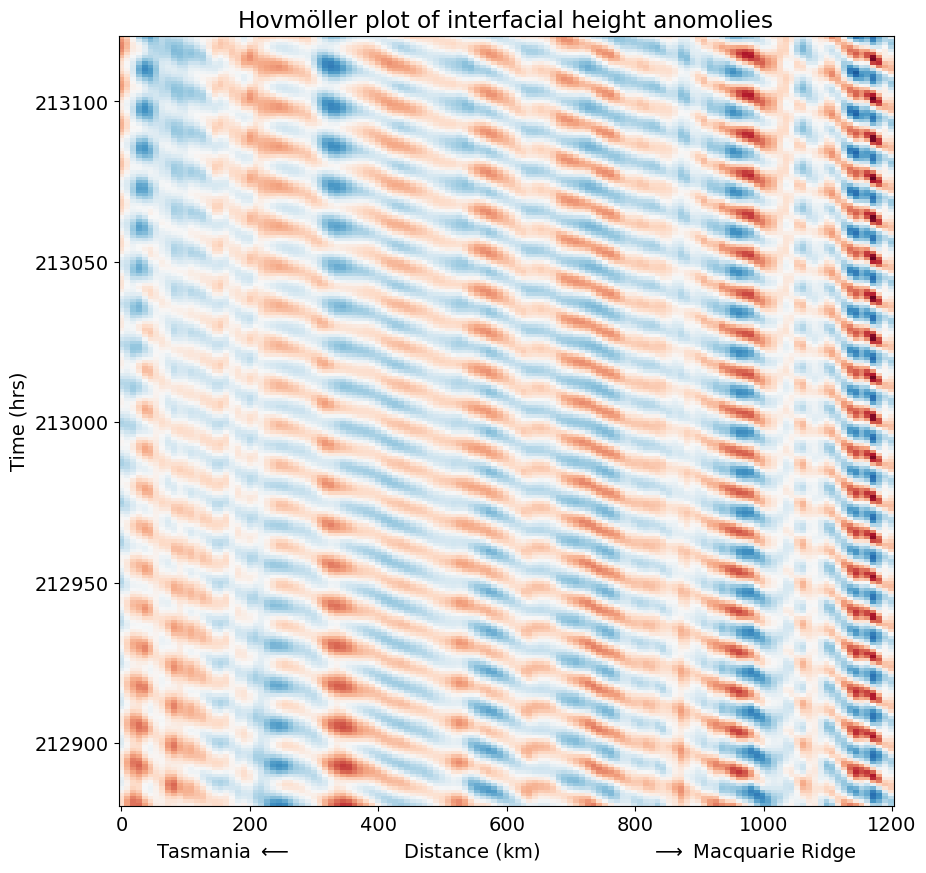

In [13]:
fig,ax = plt.subplots(1,figsize = (10,10))
data = get_transect_data(vector,"testtides-20","output010")

(data.isop_transect.isel(rho2_i = 30) - data.isop_transect.isel(rho2_i = 30).mean("time")).sel(l = slice(0,1200)).plot(ax = ax,add_colorbar = False)
ax.set_ylabel("Time (hrs)")
ax.set_xlabel(r"Tasmania $\longleftarrow $                  Distance (km)                  $\longrightarrow $ Macquarie Ridge")
ax.set_title("Hovmöller plot of interfacial height anomolies")

Text(0.5, 1.0, 'Hovmöller plot of interfacial height anomolies')

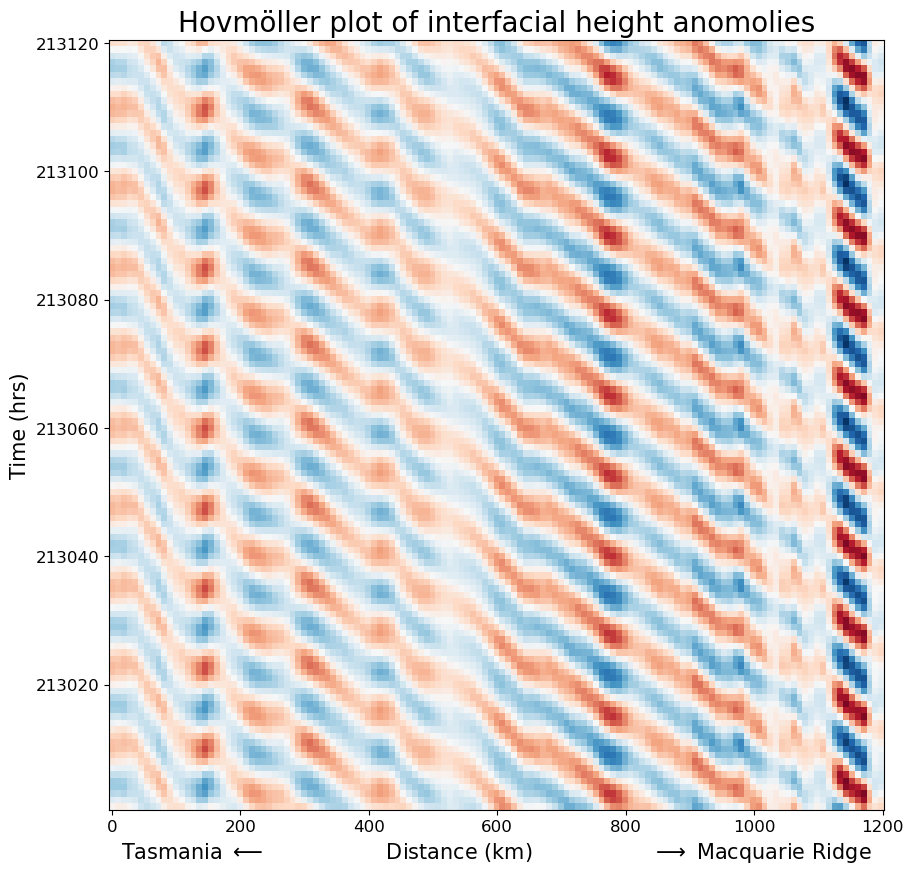

In [9]:
fig,ax = plt.subplots(1,figsize = (10,10))
data = get_transect_data(vector,"blank-ttide-20","output012")

(data.isop_transect.isel(rho2_i = 30) - data.isop_transect.isel(rho2_i = 30).mean("time")).sel(l = slice(0,1200)).plot(ax = ax,add_colorbar = False)
ax.set_ylabel("Time (hrs)")
ax.set_xlabel(r"Tasmania $\longleftarrow $                  Distance (km)                  $\longrightarrow $ Macquarie Ridge")
ax.set_title("Hovmöller plot of interfacial height anomolies")

## Hovmoller for no tides

Text(0.5, 1.0, 'Hovmöller plot of interfacial height')

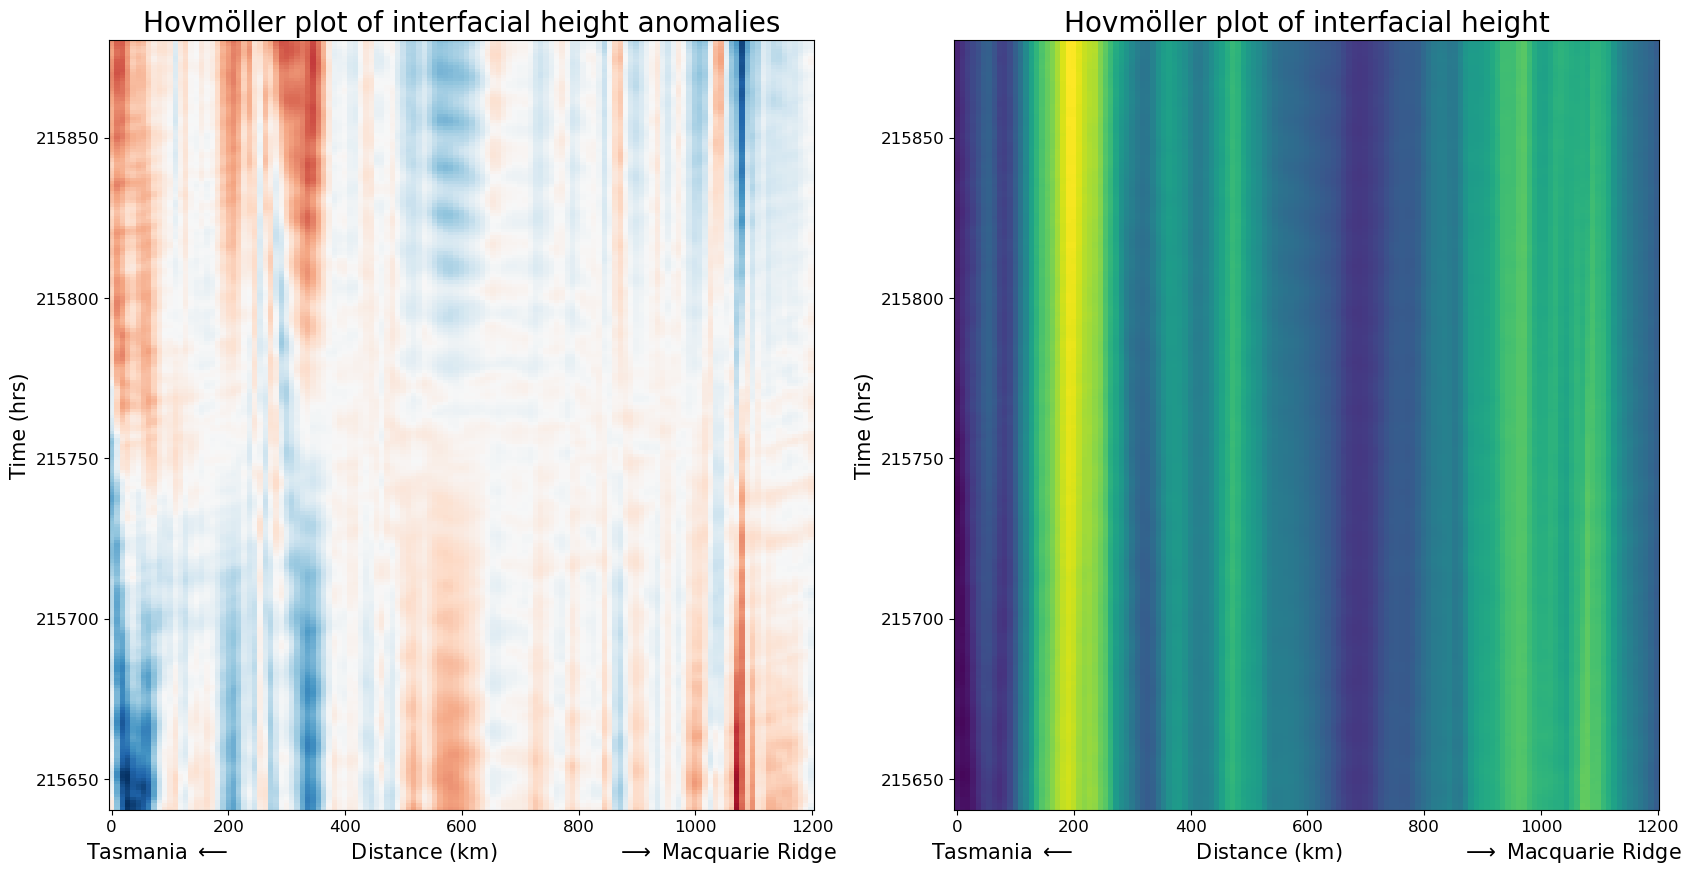

In [12]:
fig,ax = plt.subplots(1,2,figsize = (20,10))
# data = get_transect_data(vector,"ttide-20","output011")
(data.isop_transect.isel(rho2_i = 30) - data.isop_transect.isel(rho2_i = 30).mean("time")).sel(l = slice(0,1200)).plot(ax = ax[0],add_colorbar = False)
ax[0].set_ylabel("Time (hrs)")
ax[0].set_xlabel(r"Tasmania $\longleftarrow $                  Distance (km)                  $\longrightarrow $ Macquarie Ridge")
ax[0].set_title("Hovmöller plot of interfacial height anomalies")

(data.isop_transect.isel(rho2_i = 30)).sel(l = slice(0,1200)).plot(ax = ax[1],add_colorbar = False)
ax[1].set_ylabel("Time (hrs)")
ax[1].set_xlabel(r"Tasmania $\longleftarrow $                  Distance (km)                  $\longrightarrow $ Macquarie Ridge")
ax[1].set_title("Hovmöller plot of interfacial height")

## Spectra of velocity along transects

In [97]:
data = get_transect_data(vector,"ttide-20","011")


['']


2023-07-27 00:40:02,790 - distributed.worker - WARNING - Compute Failed
Key:       open_dataset-7cb26d68-a65b-4add-a88b-8f0004ec7f4b
Function:  execute_task
args:      ((<function apply at 0x15502967c820>, <function open_dataset at 0x1550111dd4c0>, [''], (<class 'dict'>, [['engine', None], ['chunks', 'auto'], ['decode_times', False]])))
kwargs:    {}
Exception: 'ValueError("did not find a match in any of xarray\'s currently installed IO backends [\'netcdf4\', \'h5netcdf\', \'scipy\', \'cfgrib\', \'cfradial1\', \'furuno\', \'gamic\', \'gini\', \'iris\', \'odim\', \'pydap\', \'radolan\', \'rainbow\', \'rasterio\', \'wradlib-cfradial1\', \'wradlib-cfradial2\', \'wradlib-furuno\', \'wradlib-gamic\', \'wradlib-iris\', \'wradlib-odim\', \'wradlib-rainbow\', \'zarr\']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:\\nhttps://docs.xarray.dev/en/stable/getting-started-guide/installing.html\\nhttps://docs.xa

ValueError: did not find a match in any of xarray's currently installed IO backends ['netcdf4', 'h5netcdf', 'scipy', 'cfgrib', 'cfradial1', 'furuno', 'gamic', 'gini', 'iris', 'odim', 'pydap', 'radolan', 'rainbow', 'rasterio', 'wradlib-cfradial1', 'wradlib-cfradial2', 'wradlib-furuno', 'wradlib-gamic', 'wradlib-iris', 'wradlib-odim', 'wradlib-rainbow', 'zarr']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html

In [4]:
data

<xarray.Dataset>
Dimensions:        (zl: 100, time: 240, l: 150, rho2_i: 80)
Coordinates:
  * zl             (zl) float64 2.704 8.126 13.58 ... 5.339e+03 5.696e+03
  * time           (time) float64 2.156e+05 2.156e+05 ... 2.159e+05 2.159e+05
    xh             (l) float64 dask.array<chunksize=(150,), meta=np.ndarray>
    yh             (l) float64 dask.array<chunksize=(150,), meta=np.ndarray>
  * l              (l) float64 0.0 9.074 18.15 ... 1.334e+03 1.343e+03 1.352e+03
  * rho2_i         (rho2_i) float64 1.036e+03 1.036e+03 ... 1.037e+03 1.037e+03
    depth          (time, zl, l) float64 dask.array<chunksize=(1, 100, 150), meta=np.ndarray>
Data variables:
    h_transect     (time, zl, l) float64 dask.array<chunksize=(1, 100, 150), meta=np.ndarray>
    isop_transect  (time, rho2_i, l) float64 dask.array<chunksize=(1, 80, 150), meta=np.ndarray>
    u_newz         (time, zl, l) float64 dask.array<chunksize=(1, 100, 150), meta=np.ndarray>

In [3]:
data.to_netcdf("/g/data/v45/ab8992/ttideoutputs/preliminary/transects/notides-output011")

In [5]:
e_point_notide = (data.isop_transect.isel(rho2_i = 50) - data.isop_transect.isel(rho2_i = 50).mean("time")).drop("xh").drop("yh").isel(l = 50).load()
u_point_notide = (data.u_newz.isel(zl = 50) - data.u_newz.isel(zl = 50).mean("time")).drop("xh").drop("yh").drop("depth").isel(l = 50).load()
N2 = xr.open_mfdataset("/home/149/ab8992/mom6_rundirs/ttide/testtides-20/archive/output011/*daily_N2.nc",decode_times = False, chunks = "auto").sel(xh = slice(145,175),yh = slice(-52,-30)).isel(time = 0,nv = 1).load()


/home/149/ab8992/.local/lib/python3.9/site-packages/xarray/core/computation.py:761: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/home/149/ab8992/.local/lib/python3.9/site-packages/xarray/core/computation.py:761: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


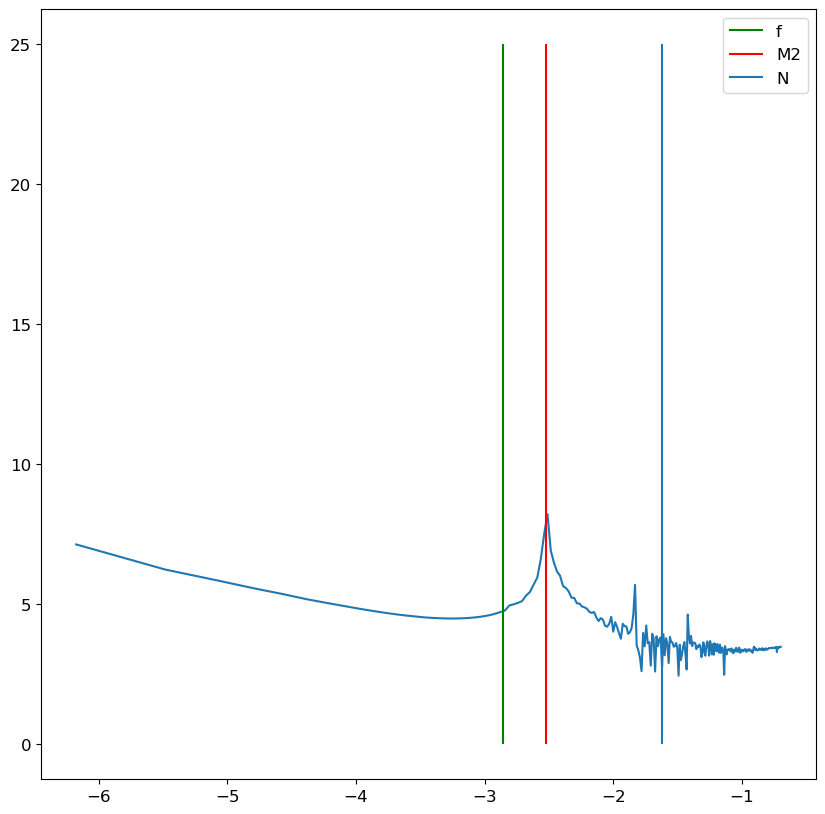

In [92]:
import xrft
fig,ax = plt.subplots(1,figsize = (10,10))
E = xrft.fft(e_point,dim="time",true_amplitude=True,true_phase=True)
# U = xrft.fft(u_point,dim="time",true_amplitude=True,true_phase=True)
# U = np.fft.fft(u_point.values)
plt.plot(np.log(E.freq_time),np.abs(np.log(E)))

m2 = 12.5
f = 0.0001 * 3600 / (np.pi * 2)
N = np.sqrt(N2.subML_N2.sel(xh = 150,yh = -43,method = "nearest").values * 3600)
ax.vlines(np.log(f),0,25,label = "f",color = "green")
ax.vlines(np.log(1/m2),0,25,label = "M2",color = "red")
ax.vlines(np.log(N),0,25,label = "N")
ax.legend()
# plt.xlim(0,None)

## notide spectra


/home/149/ab8992/.local/lib/python3.9/site-packages/xarray/core/computation.py:761: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/home/149/ab8992/.local/lib/python3.9/site-packages/xarray/core/computation.py:761: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


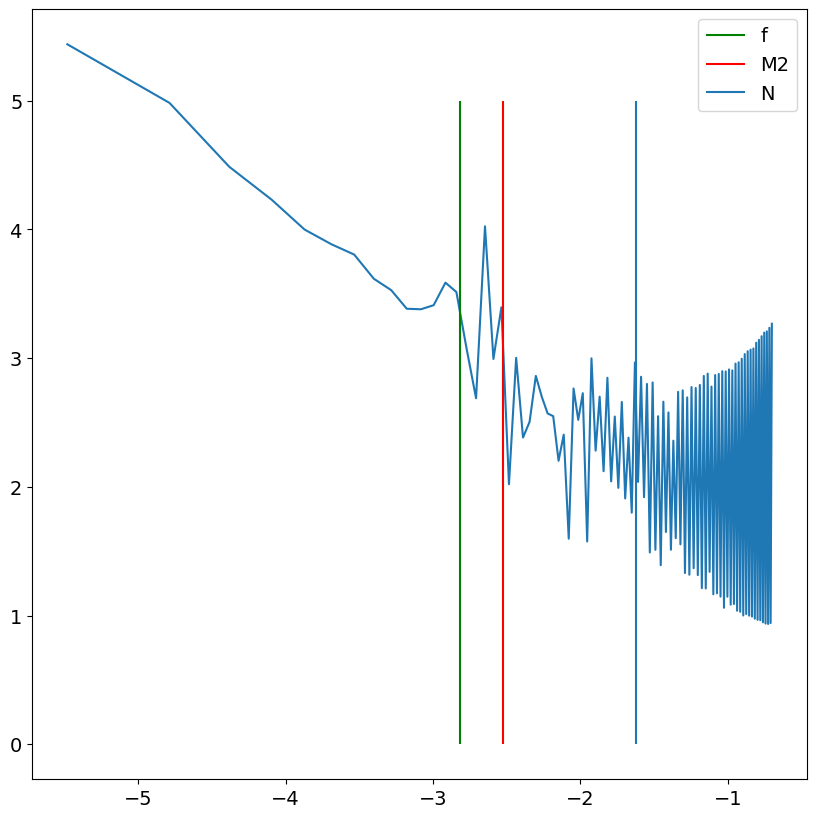

In [11]:
import xrft
fig,ax = plt.subplots(1,figsize = (10,10))
E = xrft.fft(e_point_notide,dim="time",true_amplitude=True,true_phase=True)
# U = xrft.fft(u_point,dim="time",true_amplitude=True,true_phase=True)
# U = np.fft.fft(u_point.values)
plt.plot(np.log(E.freq_time),np.abs(np.log(E)))

m2 = 12.5
f = 0.000104 * 3600 / (np.pi * 2)
# f = 0.000652 * 3600
N = np.sqrt(N2.subML_N2.sel(xh = 150,yh = -43,method = "nearest").values * 3600)
ax.vlines(np.log(f),0,5,label = "f",color = "green")
ax.vlines(np.log(1/m2),0,5,label = "M2",color = "red")
ax.vlines(np.log(N),0,5,label = "N")
ax.legend()
# plt.xlim(0,None)